In [101]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
from typing import List
from anndata import AnnData

In [102]:
# paths
nsg_bus_1 = "/mnt/shared/nationwide/Counts/NSG_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_bus_2 = "/mnt/shared/nationwide/Counts/NSG_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_bus_3 = "/mnt/shared/nationwide/Counts/NSG_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_CNTL_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_bus_1 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_2 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_3 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_3/outs/filtered_feature_bc_matrix.h5"

In [111]:
class PipelineStep:
    def apply(self, dataset):
        raise NotImplementedError()

In [129]:
class Integration(PipelineStep):
    def __init__(self, method: str = "scanorama", key: str = "Trial", resolution: int = 0.3):
        """
            Method: Integration Method
            Key: Key differentiating different datasets 
            Resolution: Clustering resolution
            will add additional parameters for normalization
        """
        self.method = method
        self.key = key
        self.resolution = resolution
    def apply(self, datasets: List[AnnData]) -> AnnData:
        """
        Parameters:
            Datasets: list of datasets to concatenate
            
        Return Value: 
            AnnData object containing PCA, Integration, Nearest Neighbor, UMAP, and Clustering results
        """
        print("Integrating Datasets")
        dataset = ad.concat(datasets)
        sc.pp.pca(dataset)
        if self.method == "scanorama":
            sce.pp.scanorama_integrate(dataset, self.key, verbose=1)
            sc.pp.neighbors(dataset, use_rep="X_scanorama")
        elif self.method == "harmony":
            sce.pp.harmony_integrate(dataset, self.key, verbose=1)
            sc.pp.neighbors(dataset, use_rep="X_pca_harmony")
        elif self.method == "merge":
            sc.pp.neighbors(dataset, use_rep="X_pca")
        else:
            raise ValueError("Invalid Integration Method")
        sc.tl.umap(dataset)
        sc.tl.leiden(
            dataset, key_added="clusters", n_iterations=2, directed=False, resolution=self.resolution
        )
        sc.pl.umap(
            dataset, color=["clusters"], palette=sc.pl.palettes.default_20
        )
        return dataset

In [130]:
class QC(PipelineStep):
    def __init__(self):
        pass
    def apply(self, datasets: List[AnnData]) -> List[AnnData]:
        """
        Parameters:
            datasets: List of AnnData objects
            
        Return Value: A List of QC'd AnnData objects
        """
        print("Quality Control")
        QC_data = []
        for data in datasets:
            sc.pp.calculate_qc_metrics(data)
            sc.pp.filter_cells(data, min_genes=100)
            sc.pp.filter_genes(data, min_cells=3)
            sc.pp.scrublet(data, batch_key="Trial")
            QC_data.append(data[data.obs["predicted_doublet"] == False])
        return QC_data

In [131]:
class Normalization(PipelineStep):
    def __init__(self, method: str = "recipe_zheng17"):
        """
        method: A string indicating how the data should be normalized
        """
        self.method = method
    def apply(self, datasets: List[AnnData]) -> List[AnnData]:
        """
        Parameters: 
            dataset: AnnData object
        Return Value: A normalized AnnData object
        """
        print("Normalizing Datasets")
        Normalized_data = []
        for data in datasets:
            Normalized_data.append(sc.pp.recipe_zheng17(data, copy=True))
        return Normalized_data

In [155]:
class Pipeline():
    def __init__(self):
        self.steps = []
    def add_step(self, step: PipelineStep) -> None:
        self.steps.append(step)
    def execute(self, data: List[AnnData]) -> AnnData:
        """
        Parameters:
            List of AnnData Objects
        Return Value: An AnnData Object
        """
        processed_data = [adata.copy() for adata in data]
        for step in self.steps:
            processed_data = step.apply(processed_data)
        return processed_data

Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processing datasets 1 <=> 2
Processing datasets 2 <=> 3
Processing datasets 1 <=> 3


/home/user/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


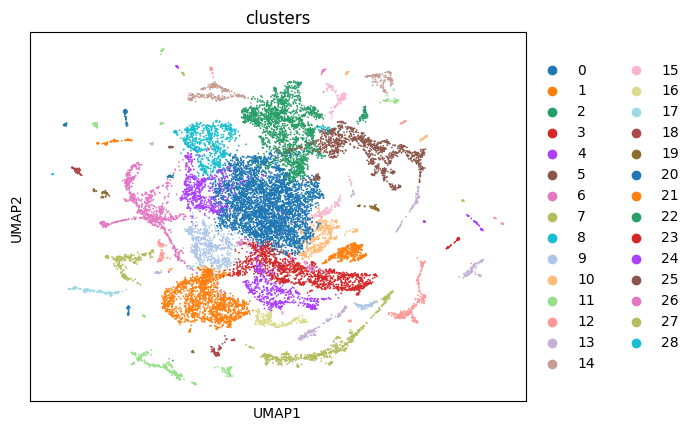

AnnData object with n_obs × n_vars = 18329 × 503
    obs: 'Trial', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_counts_all', 'clusters'
    uns: 'pca', 'neighbors', 'umap', 'clusters', 'clusters_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [133]:
# example of creating a pipeline
pipeline = Pipeline()
pipeline.add_step(QC())
pipeline.add_step(Normalization())
pipeline.add_step(Integration())
pipeline.execute([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

In [134]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def score_clusters(dataset: AnnData, key: str = "clusters", random_state: int = 42) -> tuple:
    """
    Parameters
        dataset: AnnData object with clusters precalculated
        key: where the clusters are located within ann data object
        random_state: for reproducibility 
    Return Value: silhouette, davies, calinksi clustering scores
    """
    sil = silhouette_score(dataset.X, dataset.obs[key], random_state=random_state)
    davies = davies_bouldin_score(dataset.X, dataset.obs[key])
    calinski = calinski_harabasz_score(dataset.X, dataset.obs[key])
    return sil, davies, calinski

# Python R Wrappers

In [170]:
import rpy2.robjects as ro
import anndata2ri

def seurat_sctransform_wrapper(datasets: List[AnnData]) -> AnnData:
     """
    datasets: List of Anndata datasets preprocessed through scanpy
    Returns: Anndata dataset with sctransform applied
    """
    # can only be used if Seurat SCTransform used
    anndata2ri.activate()
    ro.globalenv["adata"] = datasets
    r["source"]("./Rscripts/normalize.R")

    return ro.globalenv["adata"]

def seurat_rpca_wrapper(datasets: List[AnnData]) -> AnnData:
    """
    datasets: List of Anndata datasets preprocessed through scanpy
    Returns: Anndata dataset with rpca applied
    """
    # can only be used if Seurat SCTransform used
    anndata2ri.activate()
    ro.globalenv["adata"] = datasets
    r["source"]("./Rscripts/rpca.R")
    ro.r('rca <- as.SingleCellExperiment(cca)')

    return ro.globalenv["rpca"]

def seurat_cca_wrapper(datasets: List[AnnData]) -> AnnData:
    """
    datasets: List of Anndata datasets preprocessed through scanpy
    Returns: Anndata dataset with cca applied
    """
    # can only be used if Seurat SCTransform used
    anndata2ri.activate()
    ro.globalenv["adata"] = datasets
    r["source"]("./Rscripts/cca.R")
    ro.r('cca <- as.SingleCellExperiment(cca)')

    return ro.globalenv["cca"]

In [171]:
seurat_cca_wrapper([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

/tmp/ipykernel_61468/632470204.py:10: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
R[write to console]: Error in IntegrateData() : 
  argument "anchorset" is missing, with no default



RRuntimeError: Error in IntegrateData() : 
  argument "anchorset" is missing, with no default


In [172]:
test = [nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data]
for i in range(len(test)):
    test[i].write(f"/mnt/shared/nationwide/nsg_bus_{i}_data.h5ad")

# NSG Bulsulfan

In [92]:
# read data
nsg_bus_1_data = sc.read_10x_h5(nsg_bus_1)
nsg_bus_2_data = sc.read_10x_h5(nsg_bus_2)
nsg_bus_3_data = sc.read_10x_h5(nsg_bus_3)

# creating metadata
nsg_bus_1_data.obs["Trial"] = "1"
nsg_bus_2_data.obs["Trial"] = "2"
nsg_bus_3_data.obs["Trial"] = "3"

# making names unique
nsg_bus_1_data.var_names_make_unique()
nsg_bus_2_data.var_names_make_unique()
nsg_bus_3_data.var_names_make_unique()

nsg_bus_1_data.obs_names_make_unique()
nsg_bus_2_data.obs_names_make_unique()
nsg_bus_3_data.obs_names_make_unique()

nsg_bus_1_data = qc(nsg_bus_1_data)
nsg_bus_2_data = qc(nsg_bus_2_data)
nsg_bus_3_data = qc(nsg_bus_3_data)

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [174]:
nsg_bus_1_data.var

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
Xkr4,ENSMUSG00000051951,Gene Expression,mm10,158,0.026843,0.026489,97.381939,162.0,5.093750,157
Rp1,ENSMUSG00000025900,Gene Expression,mm10,4,0.000663,0.000663,99.933720,4.0,1.609438,4
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10,2444,0.645070,0.497783,59.502900,3893.0,8.267192,2392
Lypla1,ENSMUSG00000025903,Gene Expression,mm10,1446,0.299586,0.262046,76.039768,1808.0,7.500529,1415
Tcea1,ENSMUSG00000033813,Gene Expression,mm10,3584,1.161558,0.770829,40.613090,7010.0,8.855236,3510
...,...,...,...,...,...,...,...,...,...,...
Csprs,ENSMUSG00000062783,Gene Expression,mm10,143,0.024192,0.023904,97.630489,146.0,4.990433,139
Vamp7,ENSMUSG00000051412,Gene Expression,mm10,1293,0.264126,0.234381,78.574979,1594.0,7.374629,1263
Tmlhe,ENSMUSG00000079834,Gene Expression,mm10,1036,0.219387,0.198348,82.833471,1324.0,7.189168,1013
CAAA01147332.1,ENSMUSG00000095742,Gene Expression,mm10,27,0.004640,0.004629,99.552610,28.0,3.367296,26


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processing datasets 1 <=> 2
Processing datasets 2 <=> 3
Processing datasets 1 <=> 3


/home/user/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_61468/4177935437.py:27: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


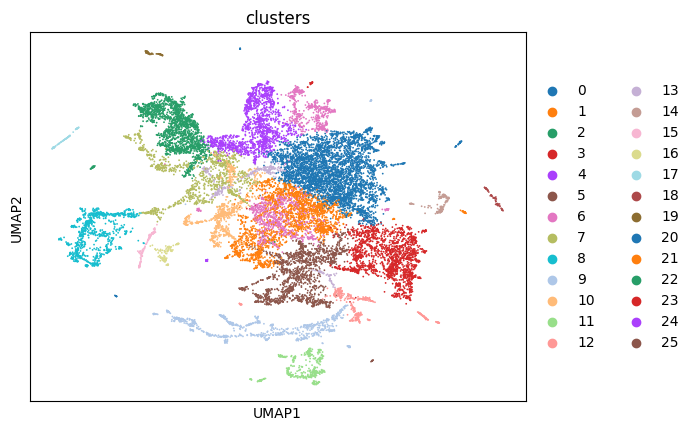

In [13]:
nsg_bus_scan = integrate([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

In [14]:
nsg_bus_harm = integrate([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data], method="harmony")

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/user/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
nsg_bus_merge = integrate([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data], method="merge")

# NSG CONTROL

In [ ]:
nsg_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_ctl_1_data.obs["Trial"] = "1"
nsg_ctl_2_data.obs["Trial"] = "2"
nsg_ctl_3_data.obs["Trial"] = "3"

nsg_ctl_1_data.var_names_make_unique()
nsg_ctl_2_data.var_names_make_unique()
nsg_ctl_3_data.var_names_make_unique()

nsg_ctl_1_data = qc(nsg_ctl_1_data)
nsg_ctl_2_data = qc(nsg_ctl_2_data)
nsg_ctl_3_data = qc(nsg_ctl_3_data)

In [ ]:
nsg_ctl_scan = integrate([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data])

In [ ]:
nsg_ctl_harm = integrate([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data], "harmony")

In [ ]:
nsg_ctl_merge = integrate([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data], "merge")

# NSG S BUS

In [ ]:
nsg_s_bus_1_data = sc.read_10x_h5(nsg_s_bus_1)
nsg_s_bus_2_data = sc.read_10x_h5(nsg_s_bus_2)
nsg_s_bus_3_data = sc.read_10x_h5(nsg_s_bus_3)

nsg_s_bus_1_data.obs["Trial"] = "1"
nsg_s_bus_2_data.obs["Trial"] = "2"
nsg_s_bus_3_data.obs["Trial"] = "3"

nsg_s_bus_1_data.var_names_make_unique()
nsg_s_bus_2_data.var_names_make_unique()
nsg_s_bus_3_data.var_names_make_unique()

nsg_s_bus_1_data = qc(nsg_ctl_1_data)
nsg_s_bus_2_data = qc(nsg_ctl_2_data)
nsg_s_bus_3_data = qc(nsg_ctl_3_data)

In [ ]:
nsg_s_bus_scan = integrate([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data])

In [ ]:
nsg_s_bus_merge = integrate([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data], "merge")

In [ ]:
nsg_s_bus_harm = integrate([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data], "harmony")

# NSG S CONTROL

In [ ]:
nsg_s_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_s_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_s_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_s_ctl_1_data.obs["Trial"] = "1"
nsg_s_ctl_2_data.obs["Trial"] = "2"
nsg_s_ctl_3_data.obs["Trial"] = "3"

nsg_s_ctl_1_data.var_names_make_unique()
nsg_s_ctl_2_data.var_names_make_unique()
nsg_s_ctl_3_data.var_names_make_unique()

nsg_s_ctl_1_data = qc(nsg_ctl_1_data)
nsg_s_ctl_2_data = qc(nsg_ctl_2_data)
nsg_s_ctl_3_data = qc(nsg_ctl_3_data)

In [ ]:
nsg_s_ctl_scan = integrate([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

In [ ]:
nsg_s_ctl_harm = integrate([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data], "harmony")

In [ ]:
nsg_s_ctl_merge = integrate([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data], "merge")

# Evaluation

In [ ]:
s_ctl = [nsg_s_ctl_merge, nsg_s_ctl_harm, nsg_s_ctl_scan]
s_bus = [nsg_s_bus_merge, nsg_s_bus_harm, nsg_s_bus_scan]
ctl = [nsg_ctl_merge, nsg_ctl_harm, nsg_ctl_scan]
bus = [nsg_bus_merge, nsg_bus_harm, nsg_bus_scan]

In [ ]:
sils = []
davies = []
calinski = []
for data in s_ctl:
    s, d, c = score_clusters(data)
    sils.append(s)
    davies.append(d)
    calinski.append(c)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

res = pd.DataFrame({"Silhouette Score": sils, "Davies Bouldin Score": davies, "Calinski Harabasz Score": calinski})
res.set_index(pd.Index(["Merge", "Harmony", "Scanorama"]), inplace=True)

In [ ]:
res.transpose()

In [ ]:
res.transpose().plot(kind="bar")